# CLV model

[Customer value in non-contractual business model](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f)

[lifetimes python package](https://github.com/CamDavidsonPilon/lifetimes) for modeling customer lifetime value (CVL). [Docs](https://lifetimes.readthedocs.io/en/latest/index.html).

[CLV in pyspark](http://webdropin.com/wordpress99/customer-lifetime-value-in-pyspark/)

[CLV broken down step-by-step](http://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix

import helper as h

In [2]:
analysis_year = '2017'
user_data_2017 = h.get_merged_data(appName='CVL-model', year=analysis_year)
user_data_2017 = user_data_2017.select(user_data_2017.login,
                                       user_data_2017.first_event,
                                       user_data_2017.last_event,
                                       user_data_2017.frequency,
                                       user_data_2017.second_period_event_count)

% of users dropped 51.772519717725196


In [3]:
user_data_2016 = h.get_merged_data(appName='CVL-model', year='2016')
user_data_2016 = user_data_2016.select(user_data_2016.login, 
                                       user_data_2016.created_at)
user_data_2016 = user_data_2016.withColumnRenamed('login', 'login2016')
user_data_2016.head()

% of users dropped 4.698526359485271


Row(login2016='0loky0', created_at=datetime.datetime(2011, 5, 24, 16, 15, 25))

In [4]:
user_data = user_data_2017.join(user_data_2016,
                                user_data_2017['login'] == user_data_2016['login2016'],
                                how='right_outer')

In [5]:
user_data = user_data.fillna(0, subset=['frequency', 'second_period_event_count'])
user_data = user_data.fillna("2016-01-01", subset=['first_event', 'last_event'])

user_data = user_data.toPandas()

In [13]:
user_data = h.add_time_columns(user_data, end_date=analysis_year + '-06-01 23:59:59')

0        2011-05-24 16:15:25
1        2016-04-14 06:04:50
2        2014-07-10 23:45:56
3        2014-04-24 10:51:26
4        2016-03-15 23:17:58
5        2016-02-17 02:40:15
6        2016-03-08 04:49:22
7        2016-03-08 04:49:22
8        2016-04-15 14:12:45
9        2014-02-11 10:03:04
10                       NaT
11                       NaT
12                       NaT
13                       NaT
14                       NaT
15                       NaT
16                       NaT
17                       NaT
18                       NaT
19                       NaT
20                       NaT
21                       NaT
22                       NaT
23                       NaT
24                       NaT
25                       NaT
26                       NaT
27                       NaT
28                       NaT
29                       NaT
                 ...        
186183                   NaT
186184                   NaT
186185                   NaT
186186        

In [7]:
user_data.head()

,login,first_event,last_event,frequency,second_period_event_count,login2016,created_at,T,recency,time_between_first_last_event
0,0loky0,2017-02-09 09:01:26,2017-02-10 03:57:59,2,0,0loky0,2011-05-24 16:15:25,2199.0,2088.487894,0.789271
1,None,NaT,NaT,0,0,13246864965,2016-04-14 06:04:50,413.0,NaN,NaN
2,1xPdd,2017-01-15 11:05:29,2017-05-31 23:39:40,19,13,1xPdd,2014-07-10 23:45:56,1056.0,1055.995648,136.523738
3,2582056905xy,2017-03-29 03:57:52,2017-05-22 03:46:50,7,16,2582056905xy,2014-04-24 10:51:26,1134.0,1123.705139,53.992338
4,None,NaT,NaT,0,0,277542952,2016-03-15 23:17:58,442.0,NaN,NaN


### T, recency and frequency

Definitions from [lifetime](https://lifetimes.readthedocs.io/en/latest/Quickstart.html):

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

### Model CLV

In [8]:
n_weeks = 22

user_data['recency'] = np.floor(user_data.recency)
lifetime_df = user_data[['frequency', 'recency', 'T', 'login2016', 'second_period_event_count']]
# normalize frequency per week
#lifetime_df['frequency'] = lifetime_df.frequency / n_weeks
#lifetime_df['second_period_event_count'] = lifetime_df.second_period_event_count / n_weeks

lifetime_df = lifetime_df.dropna()

In [9]:
lifetime_df.head()

,frequency,recency,T,login2016,second_period_event_count
0,2,2088.0,2199.0,0loky0,0
2,19,1055.0,1056.0,1xPdd,13
3,7,1123.0,1134.0,2582056905xy,16
8,46,394.0,411.0,AJ340,3
9,23,1150.0,1206.0,AaronWB,23


In [10]:
lifetime_df = lifetime_df[(lifetime_df["T"] >= 0)]
lifetime_df['recency'][lifetime_df.frequency == 0] = 0
lifetime_df = lifetime_df[lifetime_df["recency"] >= 0]
#lifetime_df = lifetime_df[lifetime_df.frequency > 0]

In [11]:
lifetime_df.describe()

,frequency,recency,T,second_period_event_count
count,5.000000,5.00000,5.000000,5.000000
mean,19.400000,1162.00000,1201.200000,11.000000
std,17.155174,604.23795,641.413049,9.460444
min,2.000000,394.00000,411.000000,0.000000
25%,7.000000,1055.00000,1056.000000,3.000000
50%,19.000000,1123.00000,1134.000000,13.000000
75%,23.000000,1150.00000,1206.000000,16.000000
max,46.000000,2088.00000,2199.000000,23.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2514aee48>,
      dtype=object)

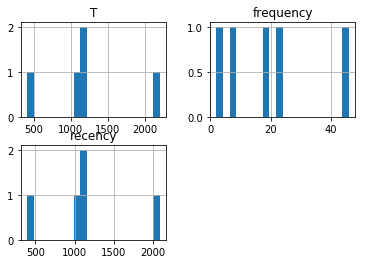

In [12]:
lifetime_df[['frequency', 'T', 'recency']].hist(bins=20)

In [50]:
# similar API to scikit-learn and lifelines.
n_users = 30000
lft_df = lifetime_df.sample(n=n_users, random_state=0)
bgf = BetaGeoFitter(penalizer_coef=1e-8)
bgf.fit(lft_df['frequency'], lft_df['recency'], lft_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 30000 subjects, a: 0.01, alpha: 1.42, b: 9.56, r: 0.23>


In [51]:
# save the model
bgf.save_model('CLV.pkl')

/home/brian/anaconda3/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


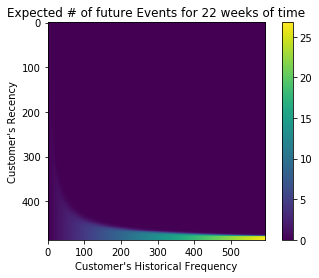

In [52]:
fig, ax = plt.subplots(1, 1)
ax = plot_frequency_recency_matrix(bgf, T=n_weeks, max_frequency=None, max_recency=None,
                             title='Expected # of future Events for {0} weeks of time'.format(n_weeks))
fig.savefig('figures/expected_number_events.png')

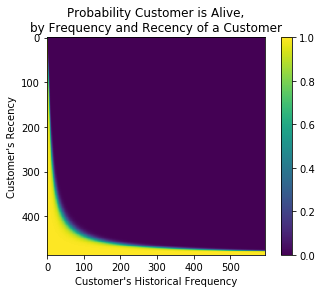

In [53]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Expected contributions in the upcoming cycle

In [54]:
lft_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(n_weeks,
                                                                                        lft_df['frequency'], 
                                                                                        lft_df['recency'], 
                                                                                        lft_df['T'])
lft_df.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,login2016,second_period_event_count,predicted_purchases
177053,548,84.0,85.0,abmorris,214,138.070097
98023,396,59.0,60.0,deepin-jenkins,488,139.604278
52378,450,69.0,69.0,Scabandari,79,140.470387
68513,383,52.0,52.0,lsrdg,94,157.558420
32160,570,62.0,63.0,jknpj,483,173.847916


[[1.         0.48106374]
 [0.48106374 1.        ]]


44.47203399515424

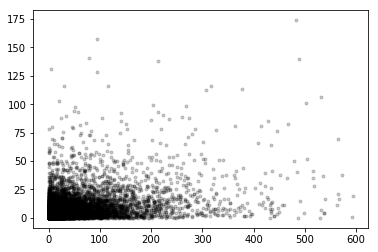

In [55]:
#user_data.dtypes
#predict_df = predict_df[predict_df.second_period_event_count < 60]
#lft_df['predicted_purchases'] = lft_df.predicted_purchases
plt.plot(lft_df.second_period_event_count, lft_df.predicted_purchases, 'k.', alpha=0.2)
#plt.xlim([0, 60])
#plt.ylim([0, 60])

print(np.corrcoef(lft_df.predicted_purchases, lft_df.second_period_event_count))
np.sqrt(np.mean((lft_df.predicted_purchases - lft_df.second_period_event_count) ** 2))

In [56]:
lft_df['probability_alive'] = bgf.conditional_probability_alive(1, lft_df['frequency'], 
                                                                  lft_df['recency'], n_weeks)
lft_df['alive'] = lft_df['probability_alive'] > 0.5
lft_df.head(15)

,frequency,recency,T,login2016,second_period_event_count,predicted_purchases,probability_alive,alive
112744,7,75.0,76.0,Displax,15,2.050722,0.985883,True
99066,0,0.0,237.0,felicien-brochu,0,0.020845,0.999042,True
58596,19,288.0,290.0,wiltodelta,5,1.450505,0.975865,True
29776,0,0.0,110.0,Joeluck,0,0.044602,0.999042,True
143973,25,235.0,238.0,jankoulaga,13,2.316373,0.986121,True
47798,107,393.0,395.0,colinux,51,5.948473,0.995353,True
46409,3,54.0,68.0,synetiq-server,0,1.020160,0.979167,True
59296,14,254.0,263.0,obibring,40,1.182532,0.970931,True
47872,2,208.0,219.0,excelmaster,0,0.221923,0.870581,True
94722,11,123.0,125.0,supportbeam,7,1.951562,0.984095,True


In [57]:
TP = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count > 0))
FP = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count > 0))
FN = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count < 1))
TN = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count < 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1score = 2 * (precision * recall) /  (precision + recall)
print('Precision: {0}'.format(np.round(precision, 3)))
print('Recall:    {0}'.format(np.round(recall, 3)))
print('Accuracy:  {0}'.format(np.round(accuracy, 3)))
print('F1-score:  {0}'.format(np.round(f1score, 4)))
#print([TP.sum(), FP.sum()])

Precision: 1.0
Recall:    0.507
Accuracy:  0.507
F1-score:  0.6729


In [58]:
pd.DataFrame([lft_df.alive == True, lft_df.second_period_event_count > 0,
             (lft_df.alive == True) & (lft_df.second_period_event_count > 0)]).transpose()[:10]

,alive,second_period_event_count,Unnamed 0
112744,True,True,True
99066,True,False,False
58596,True,True,True
29776,True,False,False
143973,True,True,True
47798,True,True,True
46409,True,False,False
59296,True,True,True
47872,True,False,False
94722,True,True,True


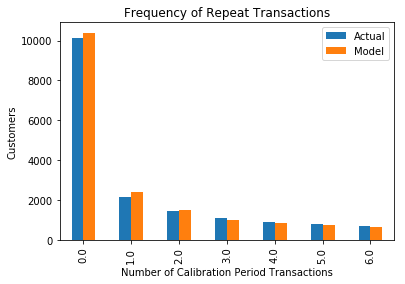

In [59]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

No handles with labels found to put in legend.


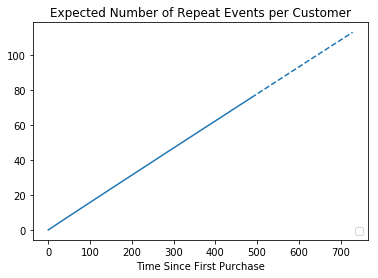

In [60]:
from lifetimes.plotting import plot_expected_repeat_purchases
plot_expected_repeat_purchases(bgf, title='Expected Number of Repeat Events per Customer')
                                   #xlabel='Time Since First Purchase',
                                   #ax=None,
                                   #label=None,
                                   #**kwargs